# Dogs vs Cats, ResNet 50 fine-tuned classifier

In [32]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.trainer as trainer
import torch.utils.trainer.plugins
from torch.autograd import Variable
import numpy as np
import os

In [2]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [3]:
# data_path = "data/dogscats/"
data_path = "data/dogscats/sample/"
use_cuda = False
batch_size = 10
print('Using CUDA:', use_cuda)

Using CUDA: False


In [4]:
# Data loading code
traindir = os.path.join(data_path, 'train')
valdir = os.path.join(data_path, 'valid')
testdir = os.path.join(data_path, 'test1')

# pytorch way of implementing fastai's get_batches, (utils.py)
def get_data_loader(dirname, shuffle=True, batch_size = 64):
    # pytorch's VGG requires images to be 224x224 and normalized using https://github.com/pytorch/vision#models
    normalize = transforms.Compose([
        transforms.Lambda(lambda img: img.resize((224, 224), Image.BILINEAR)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_folder = datasets.ImageFolder(dirname, normalize)
    return torch.utils.data.DataLoader(image_folder, batch_size=batch_size, shuffle=shuffle, pin_memory=use_cuda)

train_loader = get_data_loader(traindir, batch_size=batch_size)
val_loader = get_data_loader(valdir, shuffle=False, batch_size=batch_size)
test_loader = get_data_loader(valdir, shuffle=False, batch_size=batch_size)

In [77]:
# Load the model
model = models.resnet50(pretrained=True)

In [78]:
# Finetune by replacing the last fully connected layer and freezing all network parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer matching the new class count
classes = train_loader.dataset.classes
num_classes = len(classes)
print('Using {:d} classes: {}'.format(num_classes, classes))
expansion = 4 # TODO use Bottleneck.expansion instead
model.fc = nn.Linear(512 * expansion, num_classes)

Using 2 classes: ['cats', 'dogs']


In [79]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
# enable cuda if available
if(use_cuda):
    model.cuda()
    criterion.cuda()
optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)

In [80]:
# fine-tune with new classes
t = trainer.Trainer(model, criterion, optimizer, train_loader)
t.register_plugin(trainer.plugins.ProgressMonitor())
t.register_plugin(trainer.plugins.AccuracyMonitor())
t.register_plugin(trainer.plugins.LossMonitor())
t.register_plugin(trainer.plugins.TimeMonitor())
t.register_plugin(trainer.plugins.Logger(['progress', 'accuracy', 'loss', 'time']))

# Requires a monkey patched version of trainer.py that calls
# input_var = Variable(batch_input.cuda())    # Line 57
# target_var = Variable(batch_target.cuda())  # Line 58
epochs = 5
t.run(epochs)

progress: 1/10 (10.00%)	accuracy: 75.00%  (22.50%)	loss: 0.5343  (0.1603)	time: 0ms  (0ms)
progress: 2/10 (20.00%)	accuracy: 50.00%  (30.75%)	loss: 0.6454  (0.3058)	time: 1163ms  (349ms)
progress: 3/10 (30.00%)	accuracy: 100.00%  (51.53%)	loss: 0.3723  (0.3258)	time: 1145ms  (588ms)
progress: 4/10 (40.00%)	accuracy: 100.00%  (66.07%)	loss: 0.0359  (0.2388)	time: 1145ms  (755ms)
progress: 5/10 (50.00%)	accuracy: 50.00%   (61.25%)	loss: 2.5447  (0.9306)	time: 1127ms  (866ms)
progress: 6/10 (60.00%)	accuracy: 0.00%    (42.87%)	loss: 3.6036  (1.7325)	time: 1158ms  (954ms)
progress: 7/10 (70.00%)	accuracy: 75.00%   (52.51%)	loss: 1.2190  (1.5784)	time: 1128ms  (1006ms)
progress: 8/10 (80.00%)	accuracy: 25.00%   (44.26%)	loss: 10.4158  (4.2296)	time: 1149ms  (1049ms)
progress: 9/10 (90.00%)	accuracy: 25.00%   (38.48%)	loss: 9.4275   (5.7890)	time: 1140ms  (1076ms)
progress: 10/10 (100.00%)	accuracy: 75.00%   (49.44%)	loss: 0.2416   (4.1248)	time: 1155ms  (1100ms)
############################

In [81]:
# Define some helper functions

def denorm(tensor):
    # Undo the image normalization + clamp between 0 and 1 to avoid image artifacts
    for t, m, s in zip(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): 
        t.mul_(s).add_(m).clamp_(0, 1)
    return tensor

def get_images_to_plot(images_tensor):
    denormalize = transforms.Compose([
        transforms.Lambda(denorm)
    ])
    return denormalize(images_tensor)

def get_classes_strings(classes, labels_ids):
    # returns the classes in string format
    return [classes[label_id] for label_id in labels_ids]

def get_prediction_classes_ids(predictions):
    # returns the predictions in id format
    predictions_ids = predictions.cpu().data.numpy().argmax(1)
    return predictions_ids

def get_prediction_classes_strings(classes, predictions):
    # returns the predictions in string format
    return get_classes_strings(classes, get_prediction_classes_ids(predictions))

['cats', 'dogs', 'cats', 'cats']


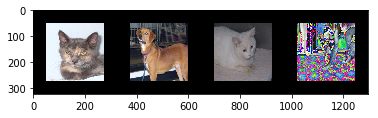

In [82]:
# display a sample set of images and their labels
train_loader = get_data_loader(valdir, batch_size = 4)
images, labels = next(iter(train_loader))
show(make_grid(get_images_to_plot(images), padding=100))
labels_string = get_classes_strings(classes, labels.numpy())
print(labels_string)

In [83]:
# display the predictons for the images above
if use_cuda:
    images = images.cuda()
predictions = model(Variable(images))
predictions_string = get_prediction_classes_strings(classes, predictions)
print(predictions_string)

['cats', 'dogs', 'cats', 'dogs']


In [91]:
import sys

def predict(val_loader, on_batch_predictions):
    # Process each mini-batch and accumulate all correct classifications
    all_predictions = [] # holds probabilities for every file id
    num_batches = sum(1 for b in enumerate(val_loader))
    batches = enumerate(val_loader)
    result = 0
    for i, (images, labels) in batches:
        sys.stdout.write('\rBatch: {:d}/{:d}'.format(i + 1, num_batches))
        sys.stdout.flush()
        if use_cuda:
            images = images.cuda()
        predictions = model(Variable(images))
        result = on_batch_predictions(images, labels, predictions, val_loader)
    # Avoid carriage return
    print('')
    return result

def get_correct_predictions():
    correct = 0
    def count_correct_predictions(images, labels, predictions, val_loader):
        nonlocal correct
        prediction_classes_ids = torch.from_numpy(get_prediction_classes_ids(predictions))
        correct += labels.eq(prediction_classes_ids).sum()
        return correct
    return count_correct_predictions

def get_all_predictions():
    all_predictions = []
    def append_predictions(images, labels, predictions, val_loader):
        nonlocal all_predictions
        dog_class_id = val_loader.dataset.class_to_idx['dogs']
        # Clamp between 0.05 and 0.95 to avoid being heavily penalized on mistakes
        predictions_prob = F.softmax(predictions).data.clamp_(0.05, 0.95)
        all_predictions.extend(predictions_prob[:,dog_class_id])
        return all_predictions
    return append_predictions

In [85]:
correct_count = predict(val_loader, get_correct_predictions())
precision = 100.0 * correct_count / len(val_loader.dataset.imgs)
print('Accuracy for validation set: {}'.format(precision))

Batch: 4/4
Accuracy for validation set: 50.0


In [92]:
import csv
import sys

def save_kaggle_predictions():
    all_predictions = predict(test_loader, get_all_predictions())
    with open("data/dogscats/predictions.csv", "wt") as f:
        writer = csv.writer(f)
        writer.writerow(("id","label"))
        for i, is_dog_probability in enumerate(all_predictions):
            row = (
                i + 1,
                is_dog_probability
            )
            writer.writerow(row)

In [93]:
save_kaggle_predictions()

Batch: 4/4
